### 目标检测任务的数据集制作
1. 边缘检测 -- opencv
2. 随机抖动
3. 转化成coco数据集的格式
4. 可视化数据集
5. 计算mean，std

In [8]:
import numpy as np
from astropy.io import fits
import random
import cv2

import numpy as np
from astropy.io import fits
import random
import os
import pandas as pd
from Tools import dr2_rgb, DESI_find_Contour


In [9]:
# savepath --  datasetpath
galaxy_name = "LSBG-galaxy"
crop_n = 1  # 每张图随机抖动n次，数据增强
save_path_data = f"/home/dell461/lys/Make_dection_json/dect-{galaxy_name}/"
data_path = f"/home/dell461/lys/Make_dection_json/{galaxy_name}-orginal/"

if not os.path.exists(save_path_data):
    os.makedirs(save_path_data)

In [10]:
def load_and_crop_fits(fits_file, crop_size=1024):
    with fits.open(fits_file) as hdul:
        data = hdul[0].data

    _, height, width = data.shape

    offset_x = random.randint(512,1000)
    offset_y = random.randint(512,1000)
    cropped_data = data[:,offset_y:offset_y + crop_size, offset_x:offset_x + crop_size]
    target_position_in_cropped = ((height // 2 - offset_y) , (width // 2 - offset_x))
    
    return data, cropped_data, target_position_in_cropped

def save_fits(data, filename):
    hdu = fits.PrimaryHDU(data)
    hdul = fits.HDUList([hdu])
    hdul.writeto(filename,overwrite=True)

In [11]:
data_box_info = []
data_path_list = [data_path+per for per in os.listdir(data_path) if "fits" in per]

for i  in data_path_list:

    fits_file = i
    data_box = {}

    for kk in range(crop_n):
    
        data_box["filename"] = save_path_data + "/crop/" + f"{kk}"+i.split("/")[-1]
    
        if not os.path.exists(os.path.dirname(data_box["filename"] )):
            os.mkdir(os.path.dirname(data_box["filename"] ))
            
        crop_size = DESI_find_Contour(fits_file)
        
        orginal_image, cropped_image, target_position = load_and_crop_fits(fits_file)

        x,y = target_position
        save_fits(cropped_image,data_box["filename"])
    
        data_box["xmin"] = y-crop_size
        data_box["ymin"] = x-crop_size
        data_box["crop_size"]  = crop_size*2

        data_box_info.append(data_box)
    print(data_box)


(3, 2048, 2048)
{'filename': '/home/dell461/lys/Make_dection_json/dect-LSBG-galaxy//crop/0cutout_0.92966_15.21798.fits', 'xmin': 154, 'ymin': -146, 'crop_size': 366}
(3, 2048, 2048)
{'filename': '/home/dell461/lys/Make_dection_json/dect-LSBG-galaxy//crop/0cutout_7.02725_25.99697.fits', 'xmin': 317, 'ymin': 320, 'crop_size': 304}
(3, 2048, 2048)
{'filename': '/home/dell461/lys/Make_dection_json/dect-LSBG-galaxy//crop/0cutout_28.46111_14.7645.fits', 'xmin': 325, 'ymin': 73, 'crop_size': 112}
(3, 2048, 2048)
{'filename': '/home/dell461/lys/Make_dection_json/dect-LSBG-galaxy//crop/0cutout_25.97973_13.80638.fits', 'xmin': 378, 'ymin': -33, 'crop_size': 212}
(3, 2048, 2048)
{'filename': '/home/dell461/lys/Make_dection_json/dect-LSBG-galaxy//crop/0cutout_22.84185_23.9542.fits', 'xmin': 29, 'ymin': 306, 'crop_size': 120}
(3, 2048, 2048)
{'filename': '/home/dell461/lys/Make_dection_json/dect-LSBG-galaxy//crop/0cutout_8.60329_24.60386.fits', 'xmin': -37, 'ymin': 123, 'crop_size': 166}
(3, 2048, 

/home/dell461/lys/Make_dection_json/Tools.py:86: RuntimeWarning: invalid value encountered in divide
  gray = np.uint8((gray - np.min(gray)) * 100 / (np.max(gray) - np.min(gray)))
/home/dell461/lys/Make_dection_json/Tools.py:86: RuntimeWarning: invalid value encountered in cast
  gray = np.uint8((gray - np.min(gray)) * 100 / (np.max(gray) - np.min(gray)))


{'filename': '/home/dell461/lys/Make_dection_json/dect-LSBG-galaxy//crop/0cutout_39.87512_29.25888.fits', 'xmin': 236, 'ymin': 150, 'crop_size': 80}
(3, 2048, 2048)
{'filename': '/home/dell461/lys/Make_dection_json/dect-LSBG-galaxy//crop/0cutout_130.71962_25.07035.fits', 'xmin': 48, 'ymin': 47, 'crop_size': 252}


In [14]:
aaaa= pd.DataFrame(data_box_info)
aaaa.to_csv(save_path_data + "galaxy_path_bbox.csv")

In [25]:
import json
import pandas as pd

def convert(dataset_df, json_file,demo="train"):

    json_dict = {"images":[], "type": "instances", "annotations": [],
                 "categories": []}
    
    categories = {"BG":0, "Target":1}
    bnd_id = 0
    image_id = 0

    if demo=="train":
        ratio=0.8
    else:
        ratio=0.2

    for line in range(int(len(dataset_df)*ratio)):

        filename = dataset_df['filename'][line].split('/')[-1].replace('.fits', '.jpg')

        if not os.path.exists(save_path_data+f"/{demo}/"):
            os.mkdir(save_path_data +f"/{demo}/")

        fitdata = fits.open(dataset_df['filename'][line])[0].data
        imagedata = 250* dr2_rgb(fitdata,["g","r","z"])[:,:,[2,1,0]]


        cv2.imwrite(save_path_data +f"/{demo}/"+filename,imagedata)
        
        image = {'file_name': filename, 'height': 256, 'width': 256,
                'id':image_id}
        json_dict['images'].append(image)

        if galaxy_name in dataset_df['filename'][line]:
      
            category_id = categories["Target"]

            xmin = int(dataset_df['xmin'][line])
            ymin = int(dataset_df['ymin'][line])
        
            o_width = int(dataset_df['crop_size'][line])
            o_height = int(dataset_df['crop_size'][line])
            ann = {'area': o_width*o_height, 'iscrowd': 0, 'image_id':
                    image_id, 'bbox':[xmin, ymin, o_width, o_height],
                    'category_id': category_id, 'id': bnd_id, 'ignore': 0,
                    'segmentation': []}
            json_dict['annotations'].append(ann)
            bnd_id += 1
            image_id += 1

        else:
            category_id = categories["BG"]
            ann = {'area': 0, 'iscrowd': 0, 'image_id':
                image_id, 'bbox':[0,0,0,0],
                'category_id': category_id, 'id': bnd_id, 'ignore': 0,
                'segmentation': []}
            json_dict['annotations'].append(ann)
            bnd_id += 1
            image_id += 1

    for cate, cid in categories.items():
        cat = {'supercategory': 'none', 'id': cid, 'name': cate}
        json_dict['categories'].append(cat)
        
    json_fp = open(json_file, 'w')
    json_str = json.dumps(json_dict)
    json_fp.write(json_str)
    json_fp.close()
    print('Completed')

    return json_dict


In [26]:
aaaa = pd.read_csv(save_path_data + "galaxy_path_bbox.csv")
if not os.path.exists(save_path_data + "/annotations/"):
    os.mkdir(save_path_data + "/annotations/")
convert(aaaa, save_path_data + "/annotations/instances_train.json","train")
convert(aaaa, save_path_data + "/annotations/instances_test.json","test")

Completed
Completed


{'images': [{'file_name': '0cutout_0.92966_15.21798.jpg',
   'height': 256,
   'width': 256,
   'id': 0},
  {'file_name': '0cutout_7.02725_25.99697.jpg',
   'height': 256,
   'width': 256,
   'id': 1}],
 'type': 'instances',
 'annotations': [{'area': 133956,
   'iscrowd': 0,
   'image_id': 0,
   'bbox': [154, -146, 366, 366],
   'category_id': 1,
   'id': 0,
   'ignore': 0,
   'segmentation': []},
  {'area': 92416,
   'iscrowd': 0,
   'image_id': 1,
   'bbox': [317, 320, 304, 304],
   'category_id': 1,
   'id': 1,
   'ignore': 0,
   'segmentation': []}],
 'categories': [{'supercategory': 'none', 'id': 0, 'name': 'BG'},
  {'supercategory': 'none', 'id': 1, 'name': 'Target'}]}

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


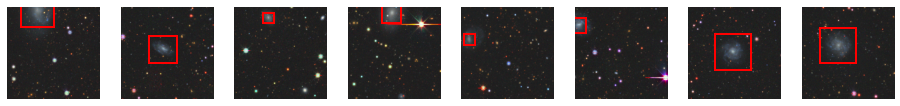

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


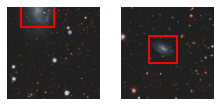

In [29]:
import matplotlib.pyplot as plt
from pycocotools.coco import COCO


# Train datasetshow
json_file = save_path_data + "/annotations/instances_train.json"
dataset_dir = save_path_data + "/train/"
coco = COCO(json_file)
catIds = coco.getCatIds(catNms=['Target']) 
imgIds = coco.getImgIds(catIds=catIds ) 

plt.figure(figsize=(20,20))
for i in range(len(imgIds)):
    img = coco.loadImgs(imgIds[i])[0]
    
    image = plt.imread(dataset_dir + img['file_name'])
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    annos = coco.loadAnns(annIds)

    bbox = annos[0]['bbox']
    x, y, w, h = bbox
    
    plt.subplot(10,10,i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.gca().add_patch(plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2))
    
plt.show()

# Test datasetshow
json_file = save_path_data + "/annotations/instances_test.json"
dataset_dir = save_path_data + "/train/"
coco = COCO(json_file)
catIds = coco.getCatIds(catNms=['Target']) 
imgIds = coco.getImgIds(catIds=catIds ) 

plt.figure(figsize=(20,20))

for i in range(len(imgIds)):
    img = coco.loadImgs(imgIds[i])[0]
    
    image = plt.imread(dataset_dir + img['file_name'])
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    annos = coco.loadAnns(annIds)

    bbox = annos[0]['bbox']
    x, y, w, h = bbox
    
    plt.subplot(10,10,i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.gca().add_patch(plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2))
    
plt.show()


In [47]:
import os  
import random  
from PIL import Image  
import numpy as np
import glob 
  
def load_images_from_folder(folder, num_images=10):
    images = []  
    image_files = glob.glob(folder + '*/*.jpg')
    if len(image_files) < num_images:  
        raise ValueError("Not enough JPG files in the directory.")  
      
    selected_files = random.sample(image_files, num_images)  
    for file in selected_files:  
        try:
            img_path = file
            img = Image.open(img_path)   
            img_array = np.array(img)  
            images.append(img_array)  
        except:
            pass
      
    return np.array(images)  
  
def calculate_mean_std(images):  

    pixels = np.concatenate(images, axis=0).reshape(-1, 3) 

    mean = np.mean(pixels, axis=0)
    std = np.std(pixels, axis=0)

    return mean, std  
  
images = load_images_from_folder(save_path_data)  
mean, std = calculate_mean_std(images)  
  
print("Mean:", mean)  
print("Std:", std)  

Mean: [41.9354641  43.16928062 40.69571095]
Std: [30.99783627 30.4794898  25.04724991]
